# Step 0: Imports
Read in our 3 favorite libraries here, plus any more you might need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime #, timezone
import pytz
import re

# Step 1: Load in Data
Read in `mission_data.csv`, a dataset containing the details of cleaning missions for a sample of 10,000 wifi-connected robots. The columns are defined as follows:

* `robotid`: a unique robot identifier
* `datetime`: a date string that represents the start time of a mission in GMT
* `nmssn`: mission number. This information comes from an internal counter on the robot that increments +1 per mission. Be aware that the complete mission history from mission 1 may not be included for each robot (due to missions being run before the robot was connected to wifi or data loss). The max mission number per robot should reflect its total number of missions to date reported to the database.
* `runm`: this is the time in minutes that the robot spent actually cleaning.
* `chrgm`: this is the time in minutes that a robot spent charging.
* `pausem`: this is the time in minutes that a robot spent paused.
* `outcome`: this is the end status of a mission. "Cncl" indicates that the mission was cancelled by the user. "Stuck" means the robot got stuck on an obstacle, and was not rescued within 90 minutes, so could not return to the dock. "Bat" means the robot's battery grew too low for it to return to the dock. "Ok" means the robot successfully completed cleaning the space and returned to the dock.

Read in `geo_data.csv`, a dataset containing the details of the robot's geographic location. The columns are defined as follows:

* `robotid`: unique robot identifier
* `country_cd`: 2-letter ISO country code
* `timezone`: robot's timezone (from IANA/Olson database)

The following sub-sections are included in Step 1:
* 1a. Load in additional dataset(s) as needed
* 1b. Data Cleaning
* 1c. Initial Data Merging

In [2]:
mission = pd.read_csv('/Users/whuard/Desktop/General_Assembly/DS-interview-challenge/data/mission_data.csv')
mission.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


In [3]:
# Take a look at how many rows and columns in this dataframe
mission.shape

(367679, 7)

In [4]:
geo = pd.read_csv('/Users/whuard/Desktop/General_Assembly/DS-interview-challenge/data/geo_data.csv')
geo.head()

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ


In [5]:
# Take a look at how many rows and columns in this dataframe
geo.shape

(10000, 3)

## 1a. Load in additional dataset as found on github to make data transformation easier

In [6]:
# Loading in country codes csv for English short name
# Downloaded from github https://gist.github.com/radcliff/f09c0f88344a7fcef373
iso_codes = pd.read_csv('data/wikipedia-iso-country-codes.csv', keep_default_na=False)

In [7]:
# Look at the iso codes dataframe
iso_codes.head()

,English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


In [8]:
# rename columns to make working with this df easier
iso_codes.columns = ['country', 'country_cd', 'alpha_3', 'numeric_code', 'iso_3166_2']
iso_codes.head()

,country,country_cd,alpha_3,numeric_code,iso_3166_2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


## 1b. Data Cleaning

In [9]:
# There are no missing values in the mission dataset
mission.isna().sum()

robotid     0
datetime    0
nmssn       0
runm        0
chrgm       0
pausem      0
outcome     0
dtype: int64

In [10]:
# There are two missing values for country_cd in 10,000 entries
geo.isna().sum()

country_cd    2
timezone      0
robotid       0
dtype: int64

In [11]:
# This will return all rows with NaN in the column specified
# As we can see we are missing the country_cd related to timezone Europe/Vaduz and Africa/Winhoek
geo[geo['country_cd'].isna()]

,country_cd,timezone,robotid
6091,NaN,Europe/Vaduz,QMJXZLREE88GULA1
6363,NaN,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [12]:
# This is to show all rows with NaN in an entire frame regardless of column
geo[geo.isnull().any(axis=1)]

,country_cd,timezone,robotid
6091,NaN,Europe/Vaduz,QMJXZLREE88GULA1
6363,NaN,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [13]:
# Filter the geo dataframe by timezone to see if there are any other entries for Europe/Vaduz
geo[geo['timezone']=='Europe/Vaduz']

,country_cd,timezone,robotid
6091,NaN,Europe/Vaduz,QMJXZLREE88GULA1
9657,NO,Europe/Vaduz,JCU2B100T9CTZT7L


In [14]:
# Since we know NO is the correct country_cod, we index the geo dataframe
# for null values of country_cd and where timezone is Europe/Vaduz and set the empyty value
# to equal 'NO', which is the correct country code
geo.loc[(geo['country_cd'].isna()) & (geo['timezone']=='Europe/Vaduz'),'country_cd']='NO'

In [15]:
# Filter the geo dataframe by the below timezone to ensure the country_cd strings are correct
geo[geo['timezone']=='Europe/Vaduz']

,country_cd,timezone,robotid
6091,NO,Europe/Vaduz,QMJXZLREE88GULA1
9657,NO,Europe/Vaduz,JCU2B100T9CTZT7L


In [16]:
# Now we filter the geo dataframe to see how many entries there are for 'Africa/Windhoek'
geo[geo['timezone']=='Africa/Windhoek']

,country_cd,timezone,robotid
6363,NaN,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [17]:
# Seeing as there is only one entry, I used google to find the correct 2-letter ISO country_cd which is NA
# https://www.nationsonline.org/oneworld/namibia.htm
# So we use the same logic above to insert NA in the correct row
geo.loc[(geo['country_cd'].isna()) & (geo['timezone']=='Africa/Windhoek'),'country_cd']='NA'

In [18]:
# Filter by county_cd == NA to ensure the string was properly updated
geo[geo.country_cd=='NA']

,country_cd,timezone,robotid
6363,NA,Africa/Windhoek,Z9JJM7JRIGJYLER2


In [19]:
# Run one last check to ensure we have no missing values
geo.isnull().sum()

country_cd    0
timezone      0
robotid       0
dtype: int64

## 1c. Initial Data Merging

In [20]:
# Reminding myself of what both dataframes look like in order to merge them together in one
mission.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


In [21]:
geo.head()

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ


In [22]:
# Look at some high level dataframe information prior to merging
mission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367679 entries, 0 to 367678
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   robotid   367679 non-null  object
 1   datetime  367679 non-null  object
 2   nmssn     367679 non-null  int64 
 3   runm      367679 non-null  int64 
 4   chrgm     367679 non-null  int64 
 5   pausem    367679 non-null  int64 
 6   outcome   367679 non-null  object
dtypes: int64(4), object(3)
memory usage: 19.6+ MB


In [23]:
# Look at some high level dataframe information prior to merging
geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country_cd  10000 non-null  object
 1   timezone    10000 non-null  object
 2   robotid     10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [24]:
# Converting the datime column from a string to a datetime
mission['datetime'] = pd.to_datetime(mission['datetime'])

In [25]:
# Confirming the datime column has the proper Dtype
mission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367679 entries, 0 to 367678
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   robotid   367679 non-null  object        
 1   datetime  367679 non-null  datetime64[ns]
 2   nmssn     367679 non-null  int64         
 3   runm      367679 non-null  int64         
 4   chrgm     367679 non-null  int64         
 5   pausem    367679 non-null  int64         
 6   outcome   367679 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 19.6+ MB


In [26]:
# Now I merge the two dataframes, I want to keep all records from the mission dataset,
# so I will use a left join. Both dataframes have a robotid and I will merge using that column
mis_geo = pd.merge(
    mission,
    geo,
    left_on='robotid',
    right_on='robotid',
    how='left'
)
# Using a left join, I will be able to see if we have mission data on robots but, missing location data
mis_geo.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo


In [27]:
# Confirming we are not missing any data in the merged dataframe
mis_geo.isna().sum()

robotid       0
datetime      0
nmssn         0
runm          0
chrgm         0
pausem        0
outcome       0
country_cd    0
timezone      0
dtype: int64

In [28]:
mis_geo.shape

(367679, 9)

# Step 2: Tasks

Perform data analysis exploring use patterns of the typical robot user per country. Include relevant visualizations where appropriate.

#### 2.1 Are there geographic differences in robot usage?
* a: Data Exploration
* b: Creating new columns Part I
* c: Explore Geographic Differences (Number of Robots per Country)
* d: Creating new columns Part II
* e: Explore Geographic Differences (Mission Outcomes)
* f: Explore Geographic Differences (Time of Day Usage)
* g: Explore Geographic Differences for time spent cleaning, charging, paused and number of missions
* h: Explore Geographic Differences (Robot Usage)

#### 2.2 Address any possible effects of data loss on your findings.
* a: Data Loss Investigation
* b: Explore mission loss prior to mission # 50

## 2.1a Data Exploration

In [29]:
# Explore the descriptive statistics for the merged mission + geo_data dataframe
mis_geo.describe()

,nmssn,runm,chrgm,pausem
count,367679.000000,367679.000000,367679.000000,367679.000000
mean,73.258984,48.906383,5.152772,6.231351
std,35.749076,29.819507,8.364238,8.202553
min,1.000000,0.000000,0.000000,0.000000
25%,47.000000,27.000000,0.000000,0.000000
50%,71.000000,47.000000,0.000000,1.000000
75%,95.000000,70.000000,11.000000,12.000000
max,248.000000,144.000000,30.000000,40.000000


In [30]:
# For each country, show the percent of the total data it represents
mis_geo.country_cd.value_counts(normalize=True).head(15)*100

IL    59.867167
CN     5.726191
FR     4.819149
JP     3.193819
CA     3.026009
AT     2.871527
DE     2.253052
US     2.235918
BE     1.393335
NO     1.230421
PL     1.193432
IT     1.183369
TW     1.124894
RU     1.069683
AU     0.843127
Name: country_cd, dtype: float64

In [31]:
# 87% of the data comes from the top 10 countries
f"{round(mis_geo.country_cd.value_counts(normalize=True).head(10).sum()*100)}% of the data is represented by the top 10 countries"

'87% of the data is represented by the top 10 countries'

In [32]:
# 92% of the data comes from the top 15 countries
f"{round(mis_geo.country_cd.value_counts(normalize=True).head(15).sum()*100)}% of the data is represented by the top 15 countries"

'92% of the data is represented by the top 15 countries'

In [33]:
# 95% of the data comes from the top 20 countries
f"{round(mis_geo.country_cd.value_counts(normalize=True).head(20).sum()*100)}% of the data is represented by the top 20 countries"

'95% of the data is represented by the top 20 countries'

## 2.1b Create new columns for deeper exploration and analysis

In [34]:
# Remind myself what the iso_codes df looks like
iso_codes.head()

,country,country_cd,alpha_3,numeric_code,iso_3166_2
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX
2,Albania,AL,ALB,8,ISO 3166-2:AL
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ
4,American Samoa,AS,ASM,16,ISO 3166-2:AS


In [35]:
iso_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       246 non-null    object
 1   country_cd    246 non-null    object
 2   alpha_3       246 non-null    object
 3   numeric_code  246 non-null    int64 
 4   iso_3166_2    246 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.7+ KB


In [36]:
# Now I merge the two dataframes, I want to keep all records from the mission dataset,
# so I will use a left join. Both dataframes have a robotid and I will merge using that column
mis_geo_iso = pd.merge(
    mis_geo,
    iso_codes[['country', 'country_cd']],
    left_on='country_cd',
    right_on='country_cd',
    how='left'
)
# Take a look at the resulting df to ensure the output is as expected
mis_geo_iso.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo,Japan
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo,Japan
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo,Japan
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo,Japan
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo,Japan


In [37]:
# Explore the column dats type information
mis_geo_iso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367679 entries, 0 to 367678
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   robotid     367679 non-null  object        
 1   datetime    367679 non-null  datetime64[ns]
 2   nmssn       367679 non-null  int64         
 3   runm        367679 non-null  int64         
 4   chrgm       367679 non-null  int64         
 5   pausem      367679 non-null  int64         
 6   outcome     367679 non-null  object        
 7   country_cd  367679 non-null  object        
 8   timezone    367679 non-null  object        
 9   country     367671 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 30.9+ MB


## 2.1c Explore Geographic Differences (Number of Robots per Country)


In [38]:
# Graph the count of unique robots per country for the top 10 countries
country_robot_count = mis_geo_iso.groupby('country')['robotid'].nunique().sort_values(ascending=False).head(10)
country_robot_count.head()

country
Israel     5956
China       539
France      481
Japan       293
Austria     285
Name: robotid, dtype: int64

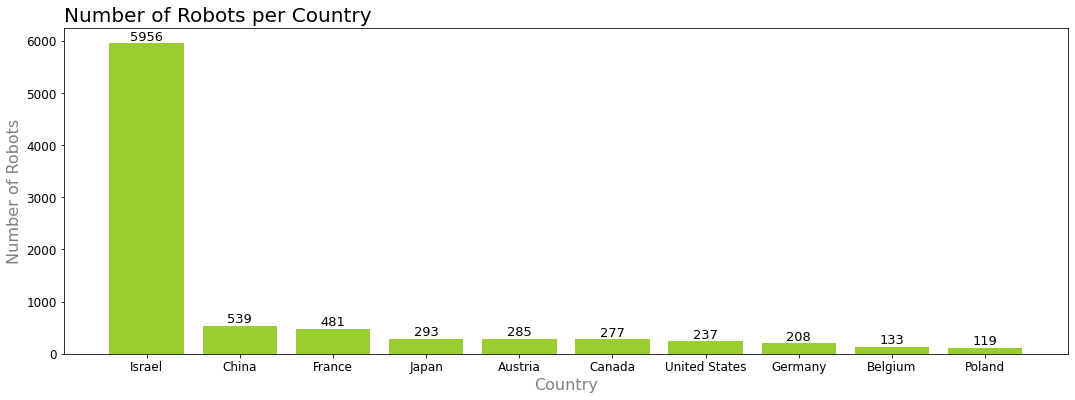

In [39]:
fig, ax = plt.subplots(figsize=(18,6))

bars = ax.bar(country_robot_count.index, country_robot_count, color='yellowgreen')

ax.bar_label(bars,label_type='edge',size=13)

plt.xticks(size=12)
plt.yticks(size=12)
# plt.xlabel('Country')
ax.set_xlabel('Country', size = 16, c='grey')
# plt.ylabel('Number of Robots')
ax.set_ylabel('Number of Robots', size=16 ,c='grey')
plt.title("Number of Robots per Country", size =20, loc='left');

plt.savefig(f"plots/fig_2c.png")

## 2.1d Create new columns for local time, hour of day, and year_month


### The following is to create the local_time column:

In [40]:
# Look at df again
mis_geo_iso.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel


In [41]:
# Write a function to convert UTC to Local Time using datetime and timezone inputs
def utc_to_local(df_datetime, df_timezone):
    # Because I previously converted the datetime column to a datetime object,
    # I need to convert it to a string for this function to work
    utc_time = datetime.strptime(str(df_datetime), '%Y-%m-%d %H:%M:%S') 
    # Return a dateime.tzinfo implementation for the given timezone
    tz = pytz.timezone(df_timezone)
    # Replace method
    utc_time = utc_time.replace(tzinfo=pytz.UTC)
    # Astimezone method
    local_time = utc_time.astimezone(tz)
    return local_time

In [42]:
# Using my function created above, create a new column for local time using the datetime and timezone for each
# row as the inputs to the function
mis_geo_iso['local_time'] = mis_geo_iso.apply(lambda x: utc_to_local(x['datetime'], x['timezone']), axis=1)
mis_geo_iso.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00


### The following is to create the hour_of_day column:

In [43]:
mis_geo_iso['hour_of_day'] = mis_geo_iso['local_time'].astype(str)

In [44]:
mis_geo_iso.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,2017-10-01 19:17:22+03:00
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,2017-10-03 17:25:56+03:00
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,2017-10-04 15:32:51+03:00
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,2017-10-26 05:12:55+03:00
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,2017-10-27 10:17:39+03:00


In [45]:
# Working with the new column to understand how I can manipulate it to extract the hour of the day
# from the string
mis_geo_iso['hour_of_day'][0]

'2017-10-01 19:17:22+03:00'

In [46]:
mis_geo_iso['hour_of_day'][0].split('-')[2]

'01 19:17:22+03:00'

In [47]:
# I found this library through googling/stackoverflow as a way to split out a string
# with multiple delimeters 
re.split('[- :]',mis_geo_iso['hour_of_day'][0])

['2017', '10', '01', '19', '17', '22+03', '00']

In [48]:
re.split('[- :]',mis_geo_iso['hour_of_day'][0])[3]

'19'

In [49]:
# Extract the hour of the day from the datetime string
mis_geo_iso['hour_of_day'] = mis_geo_iso['hour_of_day'].apply(lambda x: re.split('[- :]', x)[3])

In [50]:
# Confirm output is as expected
mis_geo_iso.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10


In [51]:
# Confirm local time and hour of day are correct as expected
mis_geo_iso[mis_geo_iso['timezone']=='America/Los_Angeles'].head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day
4648,0FSBUWPW1RJW8CBQ,2017-05-03 23:17:47,12,53,0,11,ok,US,America/Los_Angeles,United States,2017-05-03 16:17:47-07:00,16
4649,0FSBUWPW1RJW8CBQ,2017-05-06 07:31:56,13,18,0,4,cncl,US,America/Los_Angeles,United States,2017-05-06 00:31:56-07:00,00
4650,0FSBUWPW1RJW8CBQ,2017-06-03 16:16:53,14,109,0,0,ok,US,America/Los_Angeles,United States,2017-06-03 09:16:53-07:00,09
4651,0FSBUWPW1RJW8CBQ,2017-08-11 00:19:10,15,96,0,0,ok,US,America/Los_Angeles,United States,2017-08-10 17:19:10-07:00,17
4652,0FSBUWPW1RJW8CBQ,2017-08-16 04:28:17,16,75,0,0,ok,US,America/Los_Angeles,United States,2017-08-15 21:28:17-07:00,21


### The following is to create the year_month column:

In [52]:
#if the date format comes in datetime, we can also extract the day/month/year using the to_period function
#where 'D', 'M', 'Y' are inputs
mis_geo_iso['year_month'] = pd.to_datetime(mis_geo_iso['datetime']).dt.to_period('M')
mis_geo_iso.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19,2017-10
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17,2017-10
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15,2017-10
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05,2017-10
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10,2017-10


In [53]:
# the year_month column has a data type of period, which we will need to convert back to a datetime, or
# string for visualization purposes
mis_geo_iso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367679 entries, 0 to 367678
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   robotid      367679 non-null  object        
 1   datetime     367679 non-null  datetime64[ns]
 2   nmssn        367679 non-null  int64         
 3   runm         367679 non-null  int64         
 4   chrgm        367679 non-null  int64         
 5   pausem       367679 non-null  int64         
 6   outcome      367679 non-null  object        
 7   country_cd   367679 non-null  object        
 8   timezone     367679 non-null  object        
 9   country      367671 non-null  object        
 10  local_time   367679 non-null  object        
 11  hour_of_day  367679 non-null  object        
 12  year_month   367679 non-null  period[M]     
dtypes: datetime64[ns](1), int64(4), object(7), period[M](1)
memory usage: 47.3+ MB


## 2.1e Explore Geographic Differences (Mission Outcomes)

I will create new dataframes, one for each of the top 10 countries as identified by robot count above.
Then, I will explore the mission outcome distribution for each of the top 10 countries.

In [54]:
top_countries = ['Israel', 'China', 'France', 'Japan', 'Austria', 'Canada', 'United States', 'Germany',
                   'Belgium', 'Poland']

In [55]:
# Using a for loop, create a list of dataframes
list_of_df = []

for country in top_countries:
    list_of_df.append(mis_geo_iso.loc[mis_geo_iso['country']== country,:])

In [56]:
# Assign the dataframes to each respective country
israel = list_of_df[0]
china = list_of_df[1]
france = list_of_df[2]
japan = list_of_df[3]
austria = list_of_df[4]
canada = list_of_df[5]
united_states = list_of_df[6]
germany = list_of_df[7]
belgium = list_of_df[8]
poland = list_of_df[9]

In [57]:
china.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
277,024GL5LMHXQ4AXA5,2017-08-03 08:52:05,22,34,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 16:52:05+08:00,16,2017-08
278,024GL5LMHXQ4AXA5,2017-08-03 02:39:11,23,66,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:39:11+08:00,10,2017-08
279,024GL5LMHXQ4AXA5,2017-08-03 05:49:15,24,4,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 13:49:15+08:00,13,2017-08
280,024GL5LMHXQ4AXA5,2017-08-03 02:47:32,25,67,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:47:32+08:00,10,2017-08
281,024GL5LMHXQ4AXA5,2017-08-02 19:50:49,28,41,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 03:50:49+08:00,03,2017-08


In [58]:
poland.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
6604,0LZR5EBE1Q9AMOGK,2017-01-01 09:04:47,59,66,0,0,ok,PL,Europe/Warsaw,Poland,2017-01-01 10:04:47+01:00,10,2017-01
6605,0LZR5EBE1Q9AMOGK,2017-01-02 08:12:23,60,15,0,3,ok,PL,Europe/Warsaw,Poland,2017-01-02 09:12:23+01:00,09,2017-01
6606,0LZR5EBE1Q9AMOGK,2017-01-04 21:53:55,61,13,3,0,ok,PL,Europe/Warsaw,Poland,2017-01-04 22:53:55+01:00,22,2017-01
6607,0LZR5EBE1Q9AMOGK,2017-01-07 06:36:46,62,114,0,0,ok,PL,Europe/Warsaw,Poland,2017-01-07 07:36:46+01:00,07,2017-01
6608,0LZR5EBE1Q9AMOGK,2017-01-07 22:41:24,63,51,0,11,ok,PL,Europe/Warsaw,Poland,2017-01-07 23:41:24+01:00,23,2017-01


In [59]:
# The top 9 countries not including Israel
top_9_countries = ['China', 'France', 'Japan', 'Austria', 'Canada', 'United States', 'Germany',
                   'Belgium', 'Poland']

top_9 = mis_geo_iso[mis_geo_iso['country'].isin(top_9_countries)]
top_9['country'].value_counts()

China            21054
France           17719
Japan            11743
Canada           11126
Austria          10558
Germany           8284
United States     8221
Belgium           5123
Poland            4388
Name: country, dtype: int64

In [60]:
# Set a specific order for the Top 10 Countries so they are ranked from #1 to #10
top_9['country'] = pd.Categorical(top_9['country'],
                                             categories=['China', 'France', 'Japan', 'Austria', 
                                                         'Canada', 'United States', 'Germany', 'Belgium', 
                                                         'Poland'])

/var/folders/c9/kmqtft5n5dzdbw3r5rghf2qxj6_kz9/T/ipykernel_12657/573954141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_9['country'] = pd.Categorical(top_9['country'],


In [61]:
top_9.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo,Japan,2016-11-28 14:41:25+09:00,14,2016-11
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo,Japan,2016-12-20 19:06:42+09:00,19,2016-12
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo,Japan,2017-02-18 12:16:40+09:00,12,2017-02
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo,Japan,2017-03-08 19:49:36+09:00,19,2017-03
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo,Japan,2017-03-19 19:21:15+09:00,19,2017-03


In [62]:
# Create a variable that stores the count of mission outcomes for each country, excluding Israel
top_9_outcomes = top_9.groupby('country')['outcome'].value_counts()

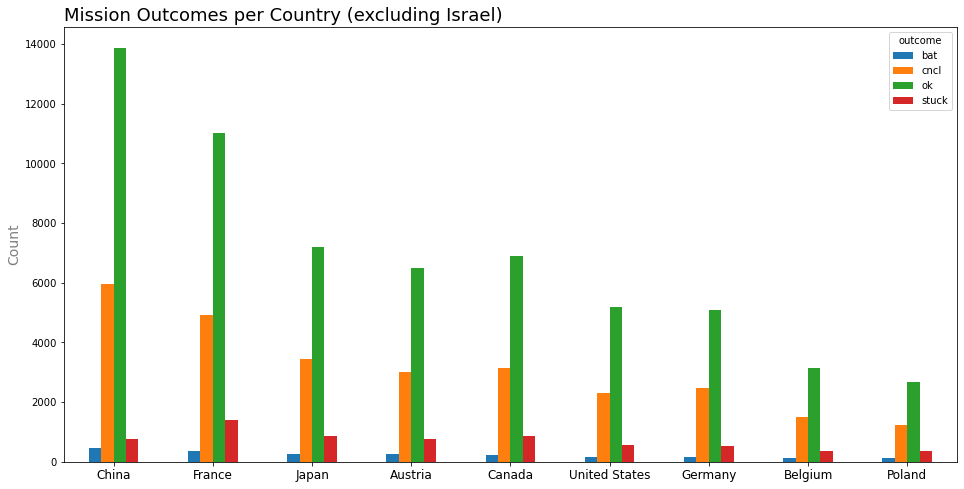

In [63]:
top_9_outcomes.unstack().plot(kind='bar', figsize=(16,8))


plt.xticks(rotation = 0, size=12)
plt.xlabel("")
plt.ylabel("Count", size=14, c='grey')
plt.title('Mission Outcomes per Country (excluding Israel)', size=18, loc='left');

plt.savefig(f"plots/fig_2e_1.png")

In [64]:
# Create a variable to store the mission outcomes for Israel
israel_outcomes = israel.groupby('country')['outcome'].value_counts()

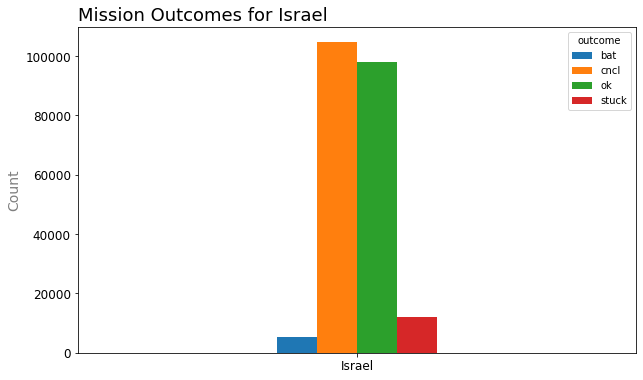

In [65]:
israel_outcomes.unstack().plot(kind='bar', width=0.2, figsize=(10,6))

plt.yticks(size=12)
plt.xticks(rotation = 0, size=12)
plt.xlabel("")
plt.ylabel("Count", size=14, c='grey')
plt.title('Mission Outcomes for Israel', size=18, loc='left');

plt.savefig(f"plots/fig_2e_2.png")

## 2.1f Explore Geographic Differences (Time of Day Usage)

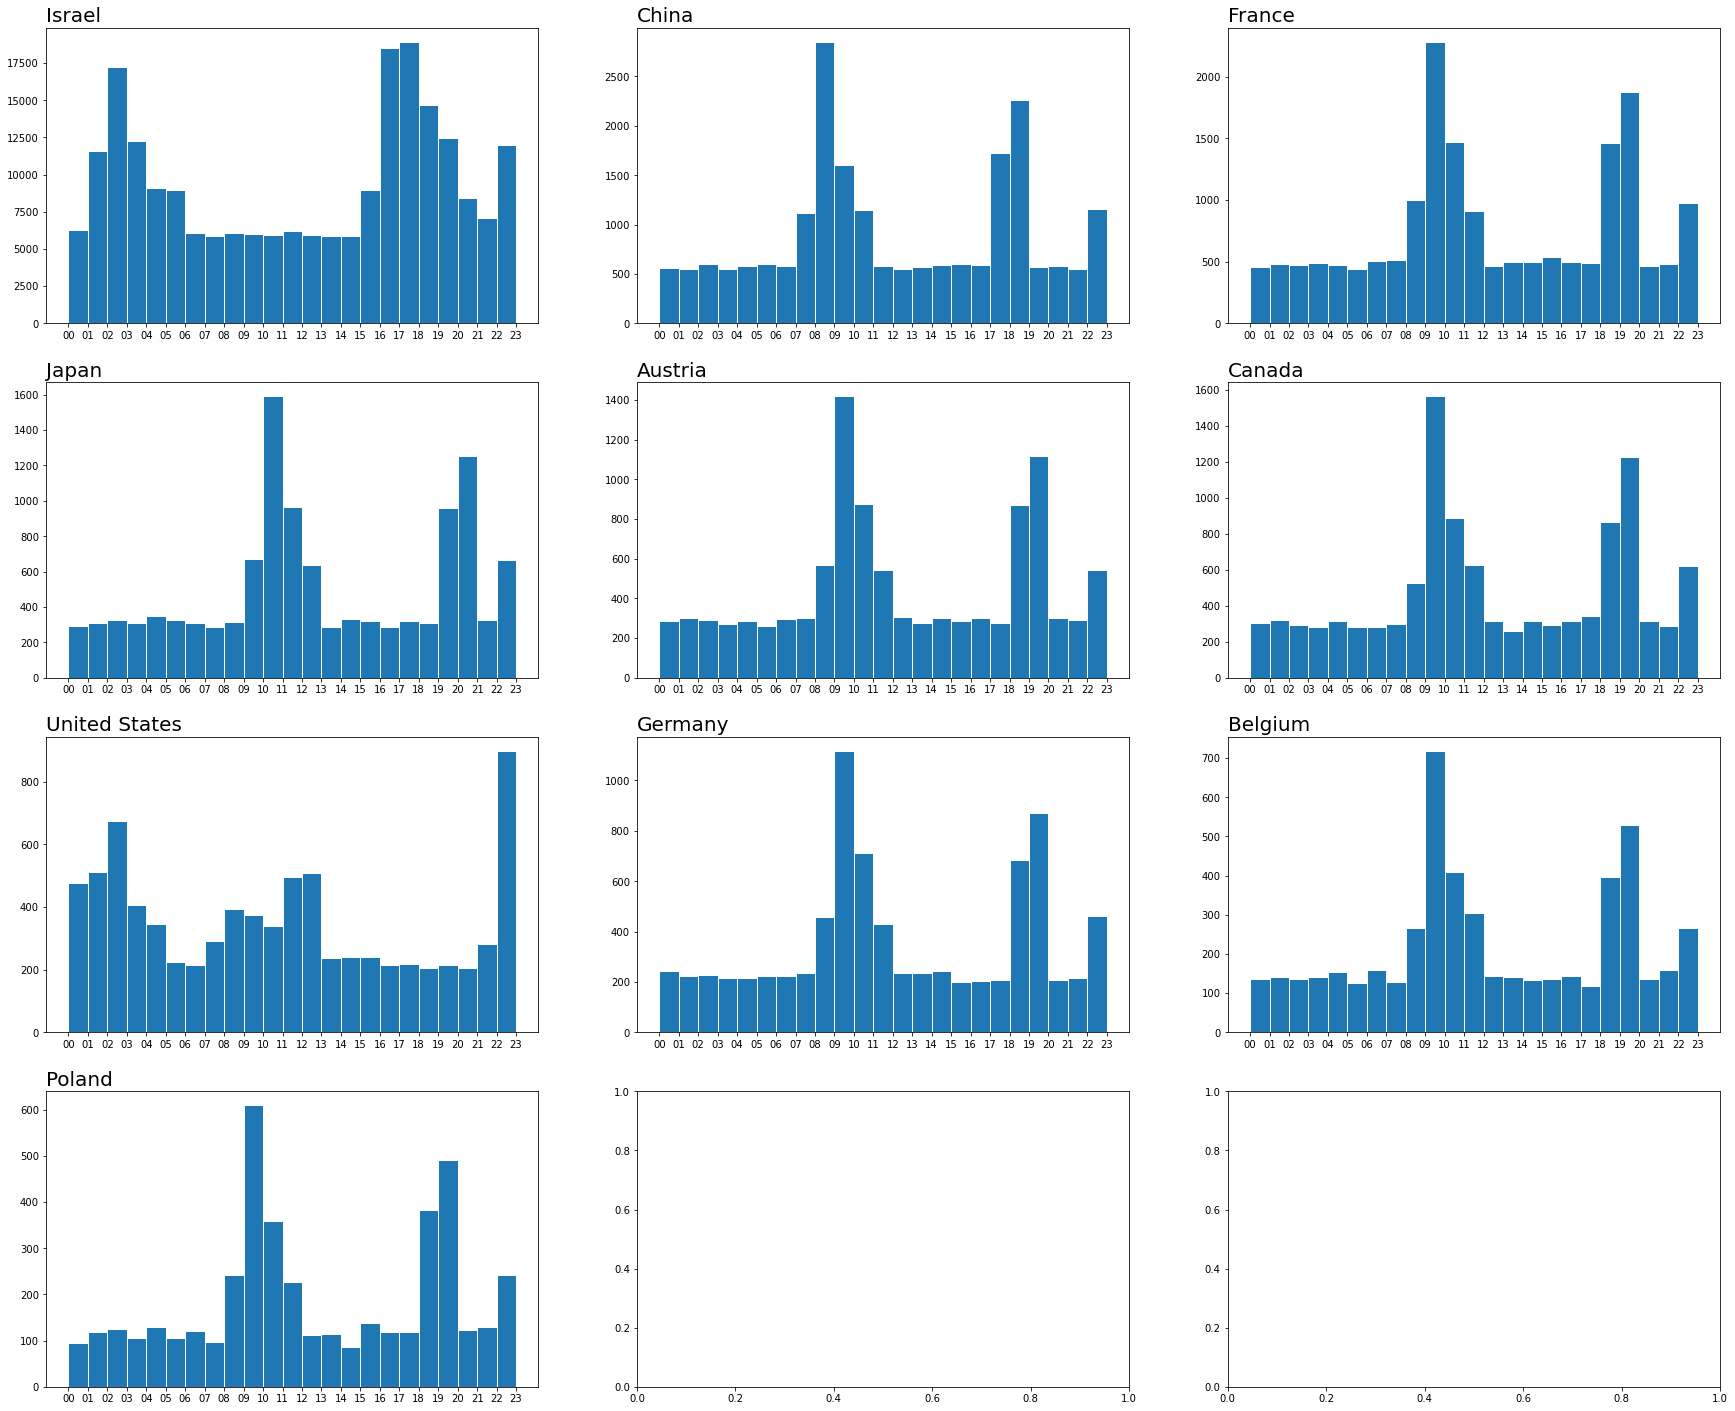

In [66]:
# Plot to the top 10 countries using subplots to pick out groups of similar behavior
fig, axs = plt.subplots(4, 3, figsize=(30, 25))

axs[0][0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][0].set_title('Israel', loc='left', size=20)

axs[0][1].hist(china.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][1].set_title('China', loc='left', size=20)

axs[0][2].hist(france.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][2].set_title('France', loc='left', size=20)

axs[1][0].hist(japan.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][0].set_title('Japan', loc='left', size=20)

axs[1][1].hist(austria.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][1].set_title('Austria', loc='left', size=20)

axs[1][2].hist(canada.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][2].set_title('Canada', loc='left', size=20)

axs[2][0].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][0].set_title('United States', loc='left', size=20)

axs[2][1].hist(germany.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][1].set_title('Germany', loc='left', size=20)

axs[2][2].hist(belgium.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][2].set_title('Belgium', loc='left', size=20)

axs[3][0].hist(poland.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][0].set_title('Poland', loc='left', size=20);

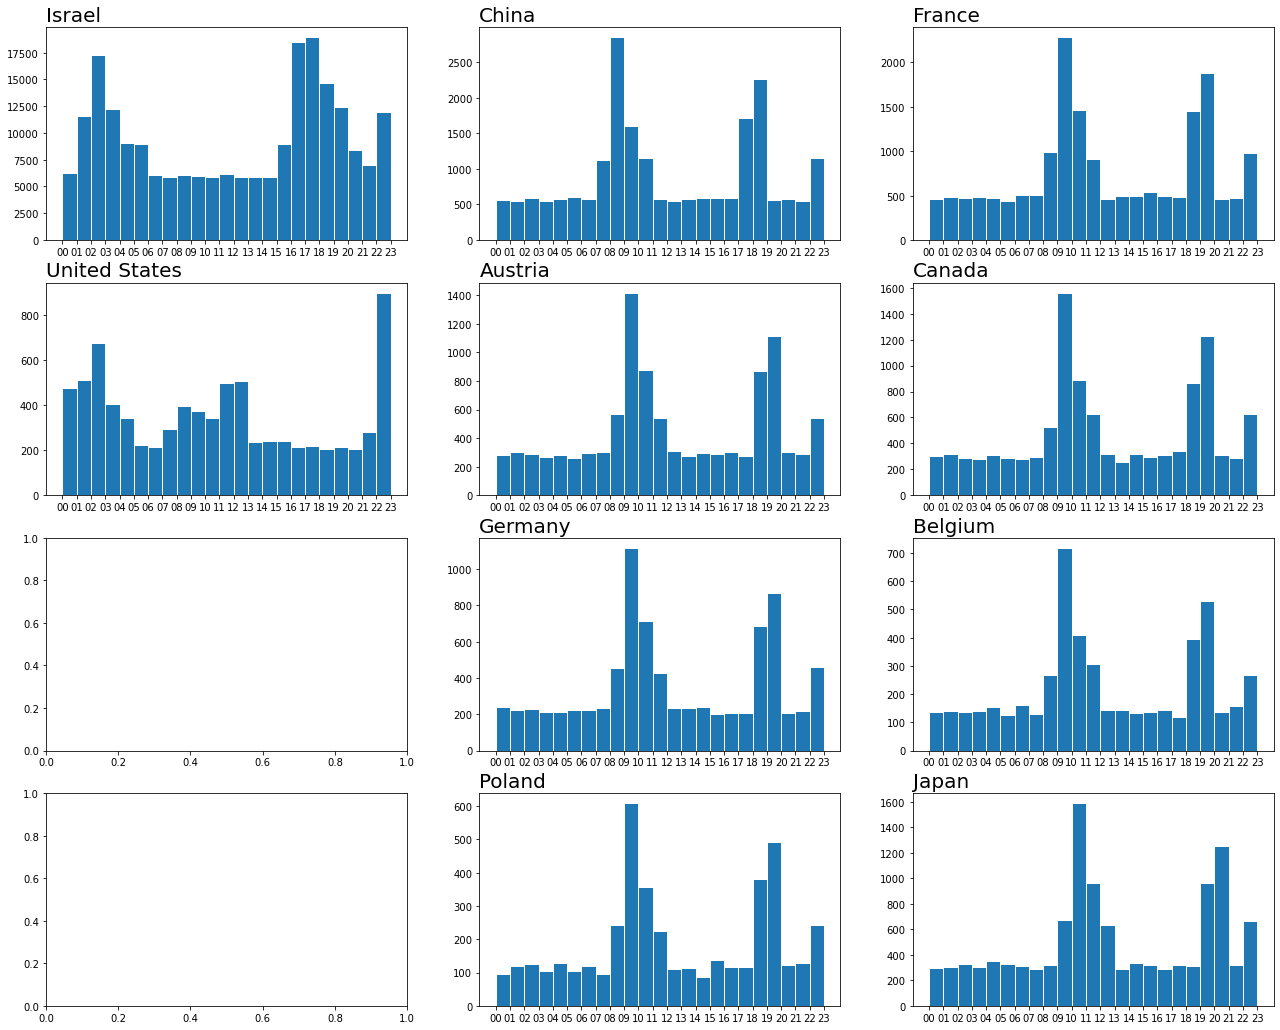

In [67]:
# After looking at the first set of subplots, I started shifting countries around to create like groupings
fig, axs = plt.subplots(4, 3, figsize=(22, 18))

axs[0][0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][0].set_title('Israel', loc='left', size=20)

axs[0][1].hist(china.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][1].set_title('China', loc='left', size=20)

axs[0][2].hist(france.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][2].set_title('France', loc='left', size=20)

axs[3][2].hist(japan.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][2].set_title('Japan', loc='left', size=20)

axs[1][1].hist(austria.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][1].set_title('Austria', loc='left', size=20);

axs[1][2].hist(canada.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][2].set_title('Canada', loc='left', size=20)

axs[1][0].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][0].set_title('United States', loc='left', size=20)

axs[2][1].hist(germany.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][1].set_title('Germany', loc='left', size=20)

axs[2][2].hist(belgium.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][2].set_title('Belgium', loc='left', size=20)

axs[3][1].hist(poland.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][1].set_title('Poland', loc='left', size=20);

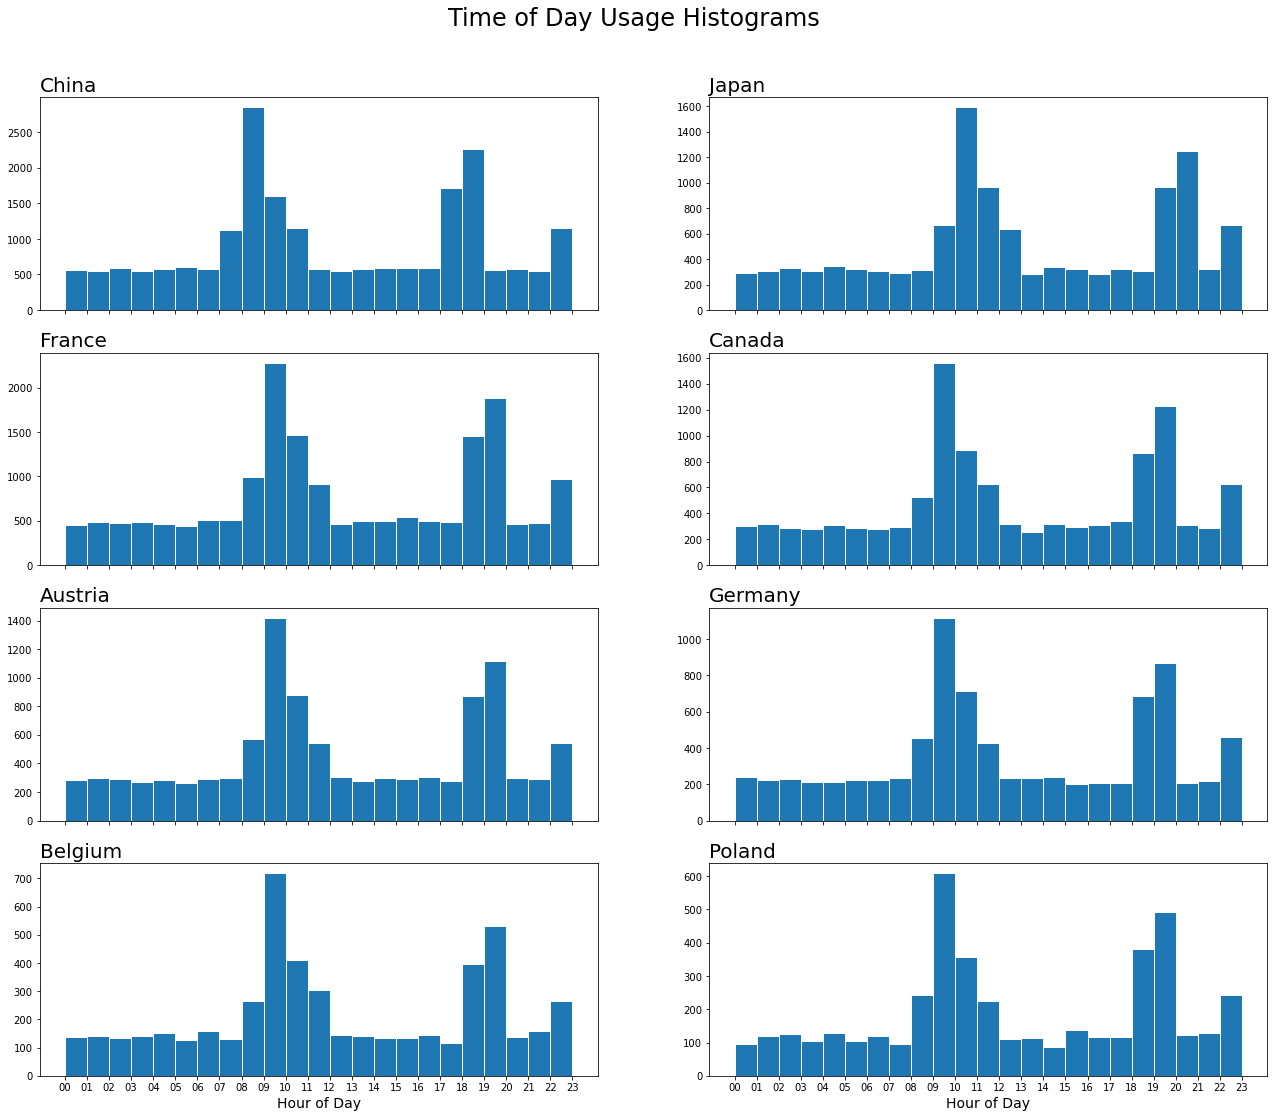

In [68]:
# I determined the following 8 had similar behavior
fig, axs = plt.subplots(4, 2, figsize=(22, 18), sharex=True)

# axs[0][0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
# axs[0][0].set_title('Israel', loc='left', size=20)

axs[0][0].hist(china.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][0].set_title('China', loc='left', size=20)

axs[1][0].hist(france.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][0].set_title('France', loc='left', size=20)

axs[0][1].hist(japan.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0][1].set_title('Japan', loc='left', size=20)

axs[2][0].hist(austria.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][0].set_title('Austria', loc='left', size=20);

axs[1][1].hist(canada.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1][1].set_title('Canada', loc='left', size=20)

# axs[1][0].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
# axs[1][0].set_title('United States', loc='left', size=20)

axs[2][1].hist(germany.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[2][1].set_title('Germany', loc='left', size=20)

axs[3][0].hist(belgium.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][0].set_title('Belgium', loc='left', size=20)
axs[3][0].set_xlabel("Hour of Day", size=14)

axs[3][1].hist(poland.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[3][1].set_title('Poland', loc='left', size=20)

plt.xlabel('Hour of Day', size=14)
fig.suptitle('Time of Day Usage Histograms', fontsize=24, y=0.95);

plt.savefig(f"plots/fig_2f_1.png")

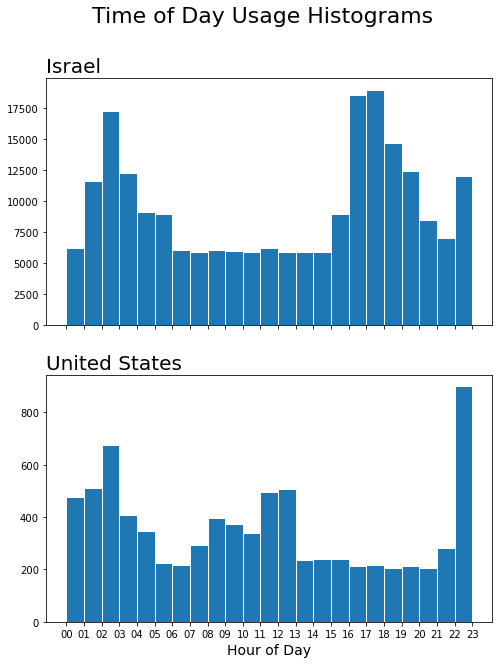

In [69]:
# Israel and the United State had somewhat similar behavior so I grouped the two countries and separated them from
# the 8 above
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

axs[0].hist(israel.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[0].set_title('Israel', loc='left', size=20)

axs[1].hist(united_states.hour_of_day.sort_values(), edgecolor='white', bins=23)
axs[1].set_title('United States', loc='left', size=20)

plt.xlabel('Hour of Day',size=14)
fig.suptitle('Time of Day Usage Histograms', fontsize=22, y=0.98);

plt.savefig(f"plots/fig_2f_2.png")

## 2.1g Explore Geographic Differences for:
### Time spent cleaning, charging, paused and number of missions

In [70]:
# Create a dataframe of the top 10 countries to explore and compare boxplots
top_10_countries = mis_geo_iso[mis_geo_iso['country'].isin(top_countries)]
top_10_countries.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19,2017-10
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17,2017-10
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15,2017-10
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05,2017-10
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10,2017-10


In [71]:
# Set a specific order for the Top 10 Countries so they are ranked from #1 to #10
top_10_countries['country'] = pd.Categorical(top_10_countries['country'],
                                             categories=['Israel', 'China', 'France', 'Japan', 'Austria', 
                                                         'Canada', 'United States', 'Germany', 'Belgium', 
                                                         'Poland'])

/var/folders/c9/kmqtft5n5dzdbw3r5rghf2qxj6_kz9/T/ipykernel_12657/3130005792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_countries['country'] = pd.Categorical(top_10_countries['country'],


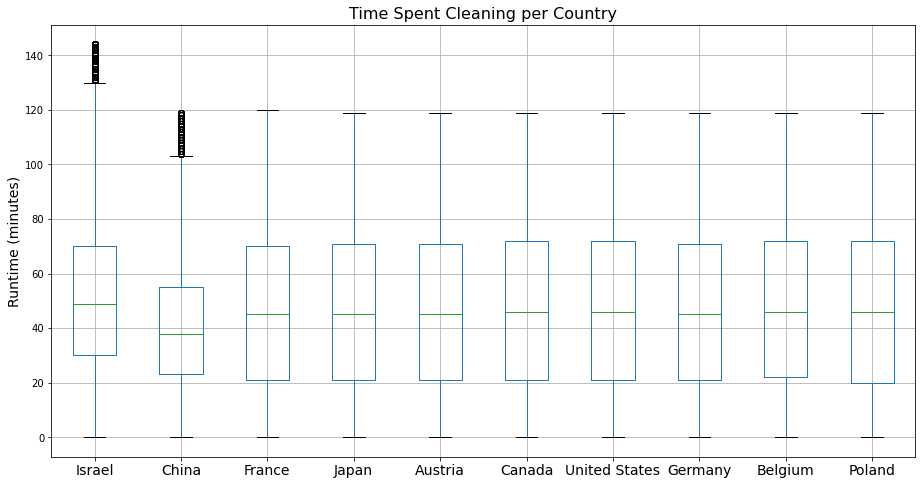

In [72]:
# These get very messy and are difficult to edit.
top_10_countries.boxplot(by='country', column='runm', figsize=(15,8), fontsize=10)

plt.title('Time Spent Cleaning per Country', size =16)
plt.suptitle('')
plt.ylabel('Runtime (minutes)', size = 14)
plt.xlabel('')
plt.xticks(fontsize=14);

plt.savefig(f"plots/fig_2g_1.png")

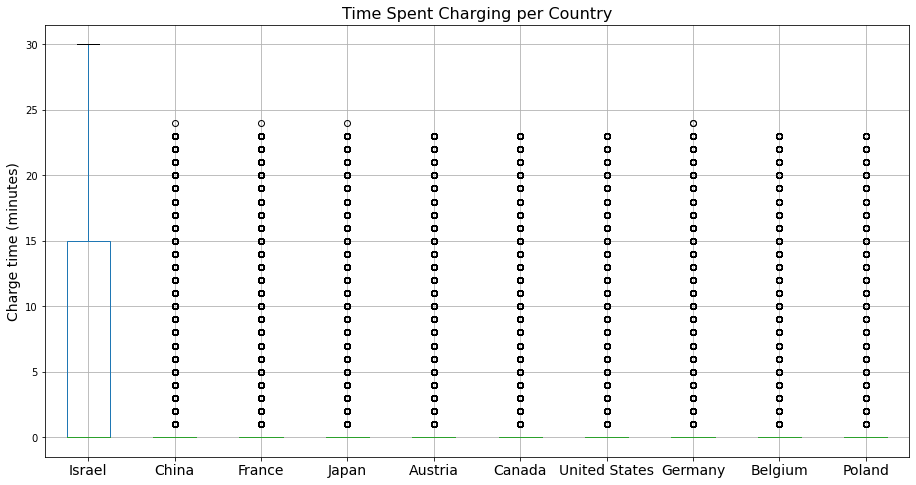

In [73]:
top_10_countries.boxplot(by='country', column='chrgm', figsize=(15,8), fontsize=10)

plt.title('Time Spent Charging per Country', size =16)
plt.suptitle('')
plt.ylabel('Charge time (minutes)', size = 14)
plt.xlabel('')
plt.xticks(fontsize=14);

plt.savefig(f"plots/fig_2g_2.png")

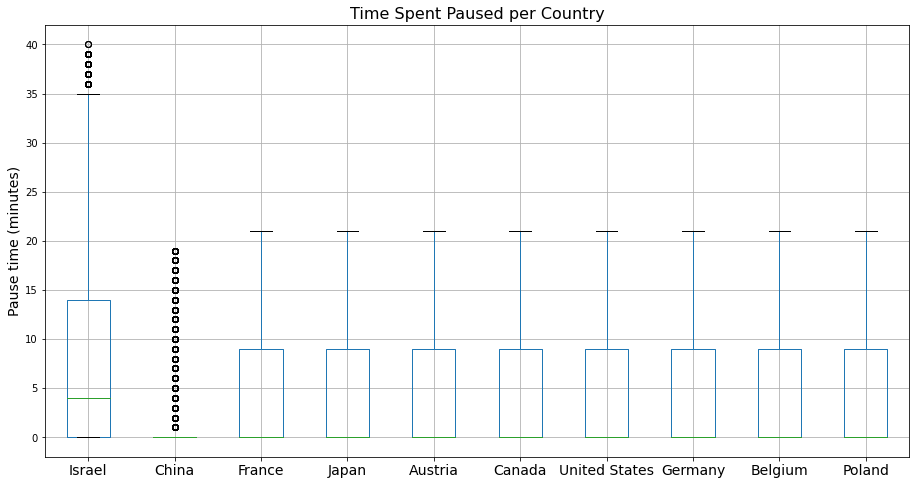

In [74]:
top_10_countries.boxplot(by='country', column='pausem', figsize=(15,8), fontsize=10)

plt.title('Time Spent Paused per Country', size =16)
plt.suptitle('')
plt.ylabel('Pause time (minutes)', size = 14)
plt.xlabel('')
plt.xticks(fontsize=14);

plt.savefig(f"plots/fig_2g_3.png")

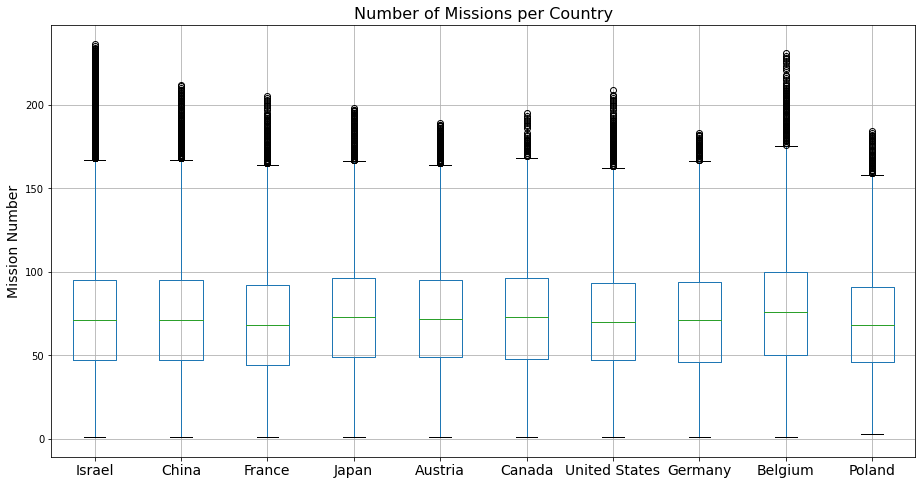

In [75]:
top_10_countries.boxplot(by='country', column='nmssn', figsize=(15,8), fontsize=10)

plt.title('Number of Missions per Country', size =16)
plt.suptitle('')
plt.ylabel('Mission Number', size = 14)
plt.xlabel('')
plt.xticks(fontsize=14);

plt.savefig(f"plots/fig_2g_4.png")

## 2.1h Explore Geographic Differences (Robot Usage)

In [76]:
israel.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,Israel,2017-10-01 19:17:22+03:00,19,2017-10
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,Israel,2017-10-03 17:25:56+03:00,17,2017-10
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,Israel,2017-10-04 15:32:51+03:00,15,2017-10
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-26 05:12:55+03:00,05,2017-10
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,Israel,2017-10-27 10:17:39+03:00,10,2017-10


In [77]:
china.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,country,local_time,hour_of_day,year_month
277,024GL5LMHXQ4AXA5,2017-08-03 08:52:05,22,34,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 16:52:05+08:00,16,2017-08
278,024GL5LMHXQ4AXA5,2017-08-03 02:39:11,23,66,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:39:11+08:00,10,2017-08
279,024GL5LMHXQ4AXA5,2017-08-03 05:49:15,24,4,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 13:49:15+08:00,13,2017-08
280,024GL5LMHXQ4AXA5,2017-08-03 02:47:32,25,67,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 10:47:32+08:00,10,2017-08
281,024GL5LMHXQ4AXA5,2017-08-02 19:50:49,28,41,0,0,ok,CN,Asia/Shanghai,China,2017-08-03 03:50:49+08:00,03,2017-08


In [78]:
# Graph the count of robots per month for israel
israel_robot_count = israel.groupby('year_month')['robotid'].size()

In [79]:
# Graph the count of robots per month for china
china_robot_count = china.groupby('year_month')['robotid'].size()

In [80]:
# Graph the count of robots per month for france
france_robot_count = france.groupby('year_month')['robotid'].size()

In [81]:
# Graph the count of robots per month for japan
japan_robot_count = japan.groupby('year_month')['robotid'].size()

In [82]:
# Graph the count of robots per month for austria
austria_robot_count = austria.groupby('year_month')['robotid'].size()

In [83]:
# Graph the count of robots per month for canada
canada_robot_count = canada.groupby('year_month')['robotid'].size()

In [84]:
# Graph the count of robots per month for united_states
usa_robot_count = united_states.groupby('year_month')['robotid'].size()

In [85]:
# Graph the count of robots per month for germany
germany_robot_count = germany.groupby('year_month')['robotid'].size()

In [86]:
# Graph the count of robots per month for belgium
belgium_robot_count = belgium.groupby('year_month')['robotid'].size()

In [87]:
# Graph the count of robots per month for poland
poland_robot_count = poland.groupby('year_month')['robotid'].size()

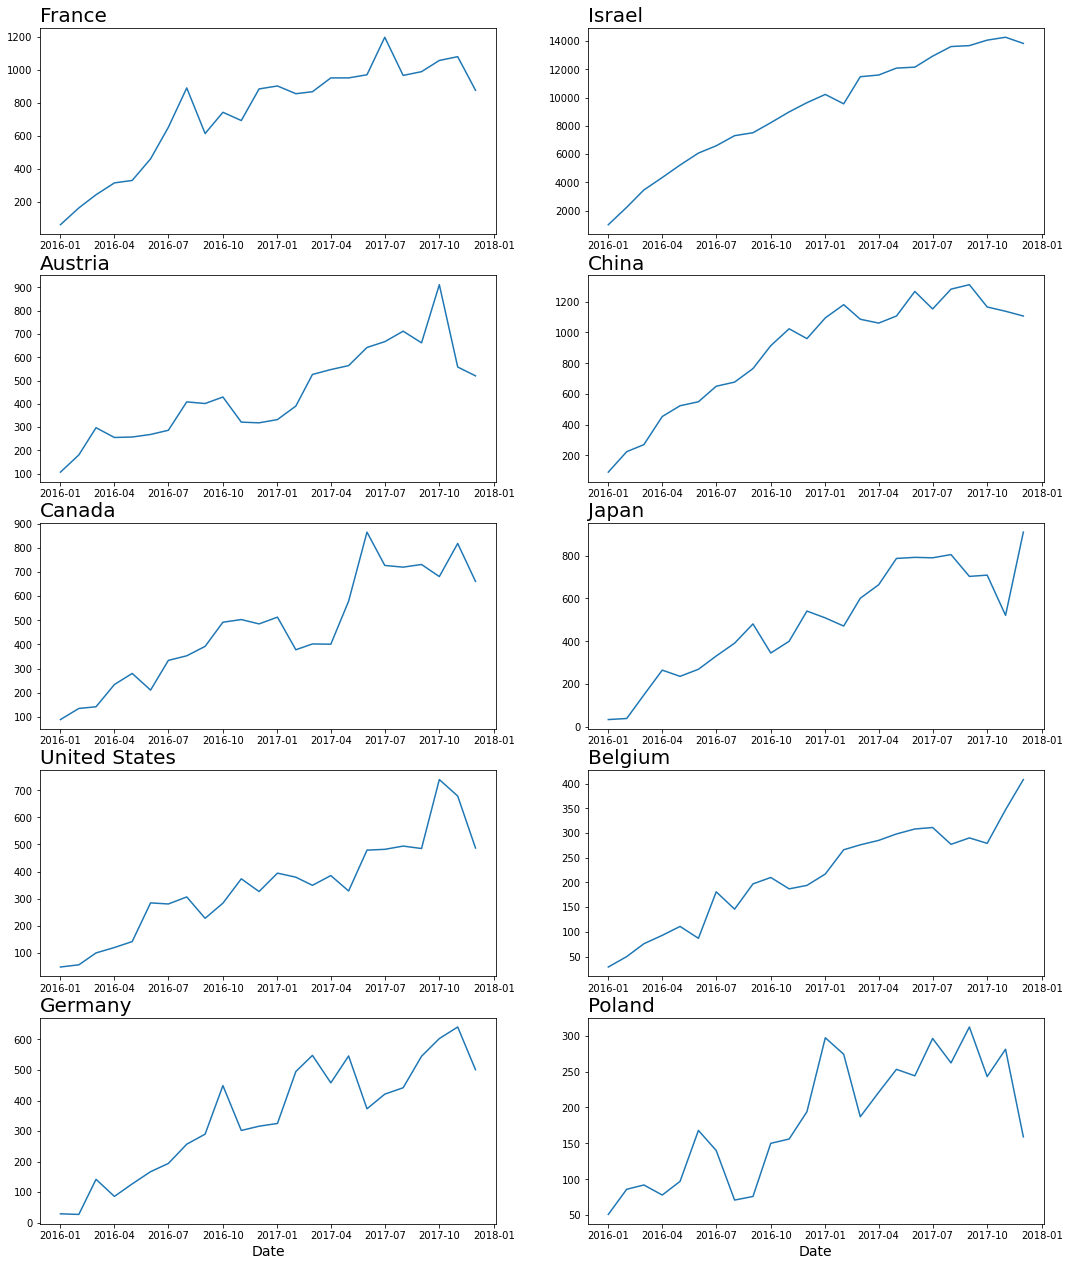

In [88]:
# Look at all missions per month for the top 10 countries to identify any patterns or similarities
fig, axs = plt.subplots(5, 2, figsize=(18, 22))

axs[0][1].plot(israel_robot_count.index.to_timestamp(), israel_robot_count)
axs[0][1].set_title('Israel', loc='left', size=20)

axs[1][1].plot(china_robot_count.index.to_timestamp(), china_robot_count)
axs[1][1].set_title('China', loc='left', size=20)

axs[0][0].plot(france_robot_count.index.to_timestamp(), france_robot_count)
axs[0][0].set_title('France', loc='left', size=20)

axs[2][1].plot(japan_robot_count.index.to_timestamp(), japan_robot_count)
axs[2][1].set_title('Japan', loc='left', size=20)

axs[1][0].plot(austria_robot_count.index.to_timestamp(), austria_robot_count)
axs[1][0].set_title('Austria', loc='left', size=20)

axs[2][0].plot(canada_robot_count.index.to_timestamp(), canada_robot_count)
axs[2][0].set_title('Canada', loc='left', size=20)

axs[3][0].plot(usa_robot_count.index.to_timestamp(), usa_robot_count)
axs[3][0].set_title('United States', loc='left', size=20)

axs[4][0].plot(germany_robot_count.index.to_timestamp(), germany_robot_count)
axs[4][0].set_title('Germany', loc='left', size=20)
axs[4][0].set_xlabel("Date", size=14)

axs[3][1].plot(belgium_robot_count.index.to_timestamp(), belgium_robot_count)
axs[3][1].set_title('Belgium', loc='left', size=20)

axs[4][1].plot(poland_robot_count.index.to_timestamp(), poland_robot_count)
axs[4][1].set_title('Poland', loc='left', size=20)


plt.xlabel('Date', size=14);

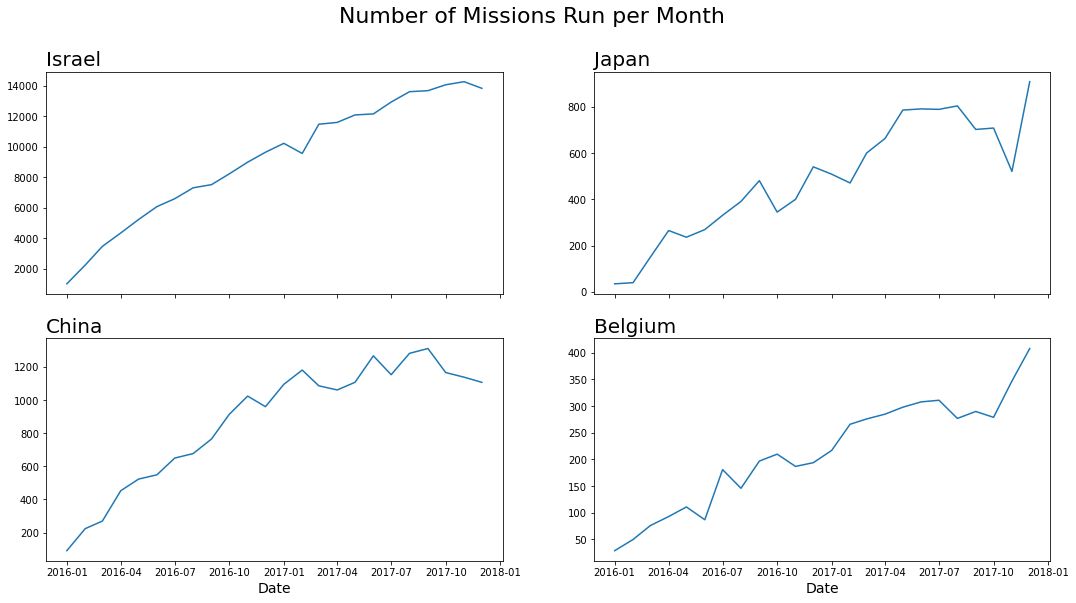

In [89]:
# Group countries with similar mission plots
fig, axs = plt.subplots(2, 2, figsize=(18, 9), sharex=True)

axs[0][0].plot(israel_robot_count.index.to_timestamp(), israel_robot_count)
axs[0][0].set_title('Israel', loc='left', size=20)

axs[1][0].plot(china_robot_count.index.to_timestamp(), china_robot_count)
axs[1][0].set_title('China', loc='left', size=20)
axs[1][0].set_xlabel("Date", size=14)

# axs[0][0].plot(france_robot_count.index.to_timestamp(), france_robot_count)
# axs[0][0].set_title('France', loc='left', size=20)

axs[0][1].plot(japan_robot_count.index.to_timestamp(), japan_robot_count)
axs[0][1].set_title('Japan', loc='left', size=20)

# axs[1][0].plot(austria_robot_count.index.to_timestamp(), austria_robot_count)
# axs[1][0].set_title('Austria', loc='left', size=20)

# axs[2][0].plot(canada_robot_count.index.to_timestamp(), canada_robot_count)
# axs[2][0].set_title('Canada', loc='left', size=20)

# axs[3][0].plot(usa_robot_count.index.to_timestamp(), usa_robot_count)
# axs[3][0].set_title('United States', loc='left', size=20)

# axs[4][0].plot(germany_robot_count.index.to_timestamp(), germany_robot_count)
# axs[4][0].set_title('Germany', loc='left', size=20)

axs[1][1].plot(belgium_robot_count.index.to_timestamp(), belgium_robot_count)
axs[1][1].set_title('Belgium', loc='left', size=20)

# axs[4][1].plot(poland_robot_count.index.to_timestamp(), poland_robot_count)
# axs[4][1].set_title('Poland', loc='left', size=20)

plt.xlabel('Date', size=14)
fig.suptitle('Number of Missions Run per Month', fontsize=22, y=0.98);

plt.savefig(f"plots/fig_2h_1.png")

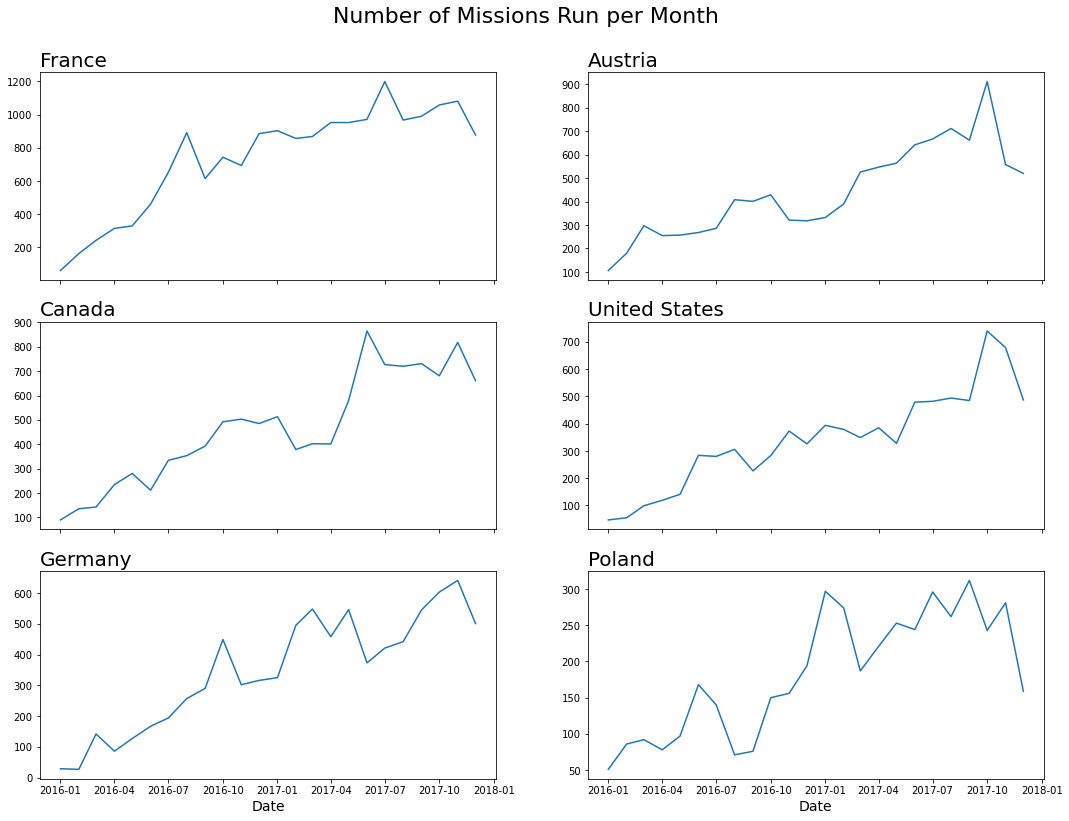

In [90]:
# Group countries with similar mission plots
fig, axs = plt.subplots(3, 2, figsize=(18, 13), sharex=True)

# axs[0][1].plot(israel_robot_count.index.to_timestamp(), israel_robot_count)
# axs[0][1].set_title('Israel', loc='left', size=20)

# axs[1][1].plot(china_robot_count.index.to_timestamp(), china_robot_count)
# axs[1][1].set_title('China', loc='left', size=20)

axs[0][0].plot(france_robot_count.index.to_timestamp(), france_robot_count)
axs[0][0].set_title('France', loc='left', size=20)

# axs[2][1].plot(japan_robot_count.index.to_timestamp(), japan_robot_count)
# axs[2][1].set_title('Japan', loc='left', size=20)

axs[0][1].plot(austria_robot_count.index.to_timestamp(), austria_robot_count)
axs[0][1].set_title('Austria', loc='left', size=20)

axs[1][0].plot(canada_robot_count.index.to_timestamp(), canada_robot_count)
axs[1][0].set_title('Canada', loc='left', size=20)

axs[1][1].plot(usa_robot_count.index.to_timestamp(), usa_robot_count)
axs[1][1].set_title('United States', loc='left', size=20)

axs[2][0].plot(germany_robot_count.index.to_timestamp(), germany_robot_count)
axs[2][0].set_title('Germany', loc='left', size=20)
axs[2][0].set_xlabel("Date", size=14)

# axs[3][1].plot(belgium_robot_count.index.to_timestamp(), belgium_robot_count)
# axs[3][1].set_title('Belgium', loc='left', size=20)

axs[2][1].plot(poland_robot_count.index.to_timestamp(), poland_robot_count)
axs[2][1].set_title('Poland', loc='left', size=20)


plt.xlabel('Date', size=14)
fig.suptitle('Number of Missions Run per Month', fontsize=22, y=0.95);

plt.savefig(f"plots/fig_2h_2.png")

# 2.2 Explore and Address Impacts of Potential Data Loss

## 2.2a Data Loss Investigation

In [91]:
# Check to ensure we still have 10,000 wifi-connected robots
# Looks like we have mission data on 9,826 unique robots
# Seeing as we used a left join, we can see we are missing mission data for 174 robots from the geo dataset
len(pd.unique(mis_geo['robotid']))

9826

In [92]:
# Create a dataframe with geo dataset on the left
geo_mis_missing = pd.merge(
    geo,
    mission,
    left_on='robotid',
    right_on='robotid',
    how='left'
)

In [93]:
# As we can see, we have 174 additional rows
geo_mis_missing.shape

(367853, 9)

In [94]:
geo_mis_missing.head()

,country_cd,timezone,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-10 19:15:38,16.0,26.0,0.0,5.0,ok
1,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-10 03:09:12,17.0,63.0,0.0,14.0,ok
2,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-11 17:05:58,18.0,49.0,0.0,11.0,bat
3,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-12 02:09:54,19.0,39.0,0.0,8.0,ok
4,SE,Europe/Stockholm,T29NF13ZIYISNF79,2017-08-12 16:38:55,21.0,38.0,0.0,8.0,ok


In [95]:
# Further verification of missing data for 174 robots
geo_mis_missing.isna().sum()

country_cd      0
timezone        0
robotid         0
datetime      174
nmssn         174
runm          174
chrgm         174
pausem        174
outcome       174
dtype: int64

In [96]:
# Create a dataframe of only the missing robots to send to client for future follow up
missing_robots = geo_mis_missing.loc[(geo_mis_missing.datetime.isna())]
missing_robots.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 682 to 366056
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   country_cd  174 non-null    object        
 1   timezone    174 non-null    object        
 2   robotid     174 non-null    object        
 3   datetime    0 non-null      datetime64[ns]
 4   nmssn       0 non-null      float64       
 5   runm        0 non-null      float64       
 6   chrgm       0 non-null      float64       
 7   pausem      0 non-null      float64       
 8   outcome     0 non-null      object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 13.6+ KB


In [97]:
# Check how many robots are missing from each country
missing_robots['country_cd'].value_counts()

IL    109
AT      8
CN      7
FR      6
JP      5
CA      5
DE      4
RU      4
TW      4
PL      3
IT      3
BE      2
IN      1
US      1
BR      1
HK      1
CZ      1
AU      1
MX      1
SG      1
CH      1
GB      1
NO      1
HU      1
PT      1
PH      1
Name: country_cd, dtype: int64

## 2.2b Explore mission loss prior to mission # 50
As I noticed in the boxplots above for mission number, it appears most of our mission data is between mission number 50 to 100.

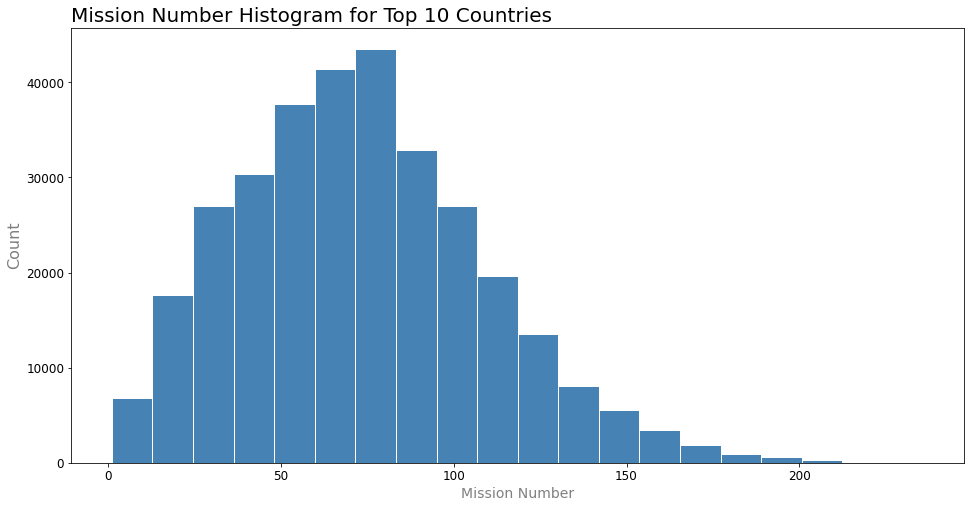

In [98]:
fig, ax = plt.subplots(figsize=(16,8))

ax.hist(top_10_countries.nmssn, edgecolor='white', bins=20, color = 'steelblue')
# bars = ax.bar(country_robot_count.index, country_robot_count, color='yellowgreen')

# ax.bar_label(bars,label_type='edge',size=13)
plt.xticks(size=12)
# plt.xticks(np.arange(0, len(x)+1, 5), size=12)
plt.yticks(size=12)
ax.set_xlabel('Mission Number', size = 14, c='grey')
ax.set_ylabel('Count', size=16 ,c='grey')
plt.title("Mission Number Histogram for Top 10 Countries", size =20, loc='left');

plt.savefig(f"plots/fig_2_2b.png")